In [2]:
%matplotlib inline

## Hyperparameters

In [4]:
MAX_SENTENCE_LENGTH = 30
nb_classes = 2
training_epochs = 50
batch_size = 256

dataset_name = 'sst2'
args = {}
args['is_hierarchical'] = False
args['max_sentence_length'] = MAX_SENTENCE_LENGTH
args['embedding_type'] = 'word2vec'
args['lambda_word'] = 3.0
args['embedding_dim'] = 300
args['attention_dim'] = 100
args['rnn_dim'] = 150
args['mu_classification'] = 1.0
args['mu_supervision'] = 1.0
args['include_dense_batch_normalization'] = False
args['include_dense_dropout'] = True
args['nb_dense'] = 1
args['dense_dim'] = 300
args['dense_dropout'] = 0.5
# args['decay'] = 2.0
# args['TVD_threshold'] = 0.3

## Dataset Preparation

In [5]:
# refer: https://torchtext.readthedocs.io/en/latest/datasets.html

import os
import csv
import torchtext

labels = {
    'negative': 0,
    'positive': 1
}

def load_dataset():
    TEXT =  torchtext.data.Field()
    LABEL = torchtext.data.Field(sequential=False)
    # remove neutral instances
    train, val, test = torchtext.datasets.SST.splits(TEXT, LABEL, filter_pred=lambda ex: ex.label != 'neutral')
    
    def torchtext2raw(data):
        x_data = []
        y_data = []
    
        for item in data:
            item = vars(item)
            x_data.append(' '.join(item['text']))
            y_data.append(labels[item['label']])
        
        return x_data, y_data
    
    train_x_data, train_y_data = torchtext2raw(train)
    val_x_data, val_y_data = torchtext2raw(val)
    test_x_data, test_y_data = torchtext2raw(test)

    return train_x_data, train_y_data, \
           val_x_data, val_y_data, \
           test_x_data, test_y_data
    
train_x_data, train_y_data, \
    val_x_data, val_y_data, \
    test_x_data, test_y_data = load_dataset()

print("len(train_x_data): {}".format(len(train_x_data)))
print("len(val_x_data): {}".format(len(val_x_data)))
print("len(test_x_data): {}".format(len(test_x_data)))

downloading trainDevTestTrees_PTB.zip


trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:01<00:00, 622kB/s] 


extracting
len(train_x_data): 6920
len(val_x_data): 872
len(test_x_data): 1821


In [7]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.tokenize import sent_tokenize

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_data)
tokenizer.fit_on_texts(test_x_data)

max_nb_words = len(tokenizer.word_index) + 1

def doc2sequential(text,
                   max_sentence_length=MAX_SENTENCE_LENGTH):
    tokenized_sentences = tokenizer.texts_to_sequences([text])
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=max_sentence_length)
    
    return tokenized_sentences[0]
            
def build_sequential_dataset(x_data, y_data,
                             max_sentence_length=MAX_SENTENCE_LENGTH,
                             tokenizer=tokenizer):
    nb_instances = len(x_data)
    X_data = np.zeros((nb_instances, max_sentence_length), dtype='int32')
    for i, review in enumerate(x_data):
        tokenized_sentence = doc2sequential(review)
        X_data[i] = tokenized_sentence[None, ...]
        
    nb_classes = len(set(y_data))
    Y_data = to_categorical(y_data, nb_classes)
    
    return X_data, Y_data

train_X_data, train_Y_data = build_sequential_dataset(train_x_data, train_y_data)
val_X_data, val_Y_data = build_sequential_dataset(val_x_data, val_y_data)
test_X_data, test_Y_data = build_sequential_dataset(test_x_data, test_y_data)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("val_X_data.shape: {}".format(val_X_data.shape))
print("test_X_data.shape: {}".format(test_X_data.shape))

train_X_data.shape: (6920, 30)
val_X_data.shape: (872, 30)
test_X_data.shape: (1821, 30)


In [8]:
embedding_dir = './embeddings/'

def load_word2vec(tokenizer=tokenizer):
    from gensim.models import KeyedVectors
    embedding_path = os.path.join(embedding_dir, 'GoogleNews-vectors-negative300.bin')
    embeddings_index = KeyedVectors.load_word2vec_format(embedding_path, binary=True)
    
    return embeddings_index
    
def load_embedding(embedding_type='word2vec',
                   tokenizer=tokenizer,
                   embedding_dim=300):
    
    if embedding_type == 'word2vec':
        embeddings_index = load_word2vec()
        
    embedding_matrix = np.random.normal(0, 1, (max_nb_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = embeddings_index[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

embedding_matrix = load_embedding('word2vec')

print("embedding_matrix.shape: {}".format(embedding_matrix.shape))

embedding_matrix.shape: (15501, 300)


## Training Teacher(BiGRU+Attention) Model

In [11]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    model = Model(inputs=[sequence_input],
                  outputs=[pred_sentiment])
    
    ############### build attention extractor ###############
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.compile(loss=['categorical_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

teacher_path = './models/checkpoints/{}-teacher.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=teacher_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

teacher, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = teacher.fit(x=[train_X_data],
                    y=[train_Y_data],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer_1/Softmax:0", shape=(?, 30), dtype=float32)
Train on 6920 samples, validate on 872 samples
Epoch 1/50
6920/6920 [==============================] - 1s 140us/step - loss: 0.6999 - acc: 0.5396 - val_loss: 0.6486 - val_acc: 0.6663
Epoch 2/50
6920/6920 [==============================] - 0s 44us/step - loss: 0.6584 - acc: 0.6033 - val_loss: 0.6191 - val_acc: 0.6663
Epoch 3/50
6920/6920 [==============================] - 0s 44us/step - loss: 0.6134 - acc: 0.6649 - val_loss: 0.5637 - val_acc: 0.7282
Epoch 4/50
6920/6920 [==============================] - 0s 45us/step - loss: 0.5801 - acc: 0.6964 - val_loss: 0.5463 - val_acc: 0.7328
Epoch 5/50
6920/6920 [==============================] - 0s 43us/step - loss: 0.5754 - acc: 0.7059 - val_loss: 0.5240 - val_acc: 0.7580
Epoch 6/50
6920/6920 [==============================] - 0s 44us/step - loss: 0.5511 - acc: 0.7199 - val_loss: 0.5050 - val_acc: 0.7672
Epoch 7/50
6920/6920 [==============================] - 0s 44us/step - los

In [12]:
teacher.load_weights(teacher_path)
teacher_score = teacher.evaluate(test_X_data, test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of teacher: {}".format(teacher_score[1]))

Test Accuracy of teacher: 0.8242723782399014


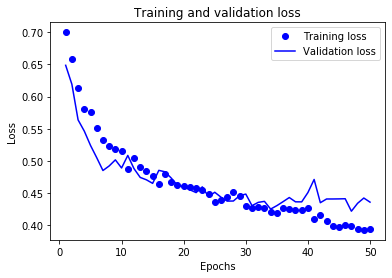

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

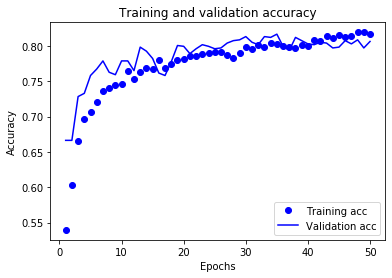

In [14]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Vanilla Knowledge Distillation

In [15]:
train_soft = teacher.predict(x=[train_X_data],
                           batch_size=batch_size,
                           verbose=True)
val_soft = teacher.predict(x=[val_X_data],
                         batch_size=batch_size,
                         verbose=True)
test_soft = teacher.predict(x=[test_X_data],
                          batch_size=batch_size,
                          verbose=True)
print(train_soft.shape)
print(val_soft.shape)
print(test_soft.shape)

1821/1821 [==============================] - 0s 14us/step
(6920, 2)
(872, 2)
(1821, 2)


In [16]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           mu_distillation=1.0,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    ############### attention supervision processing ###############
    soft_label = Input(shape=(nb_classes, ), dtype='float32')  # should it be logit?
    
    ############### build attention extractor ###############
    model = Model(inputs=[sequence_input, soft_label],
                  outputs=[pred_sentiment])
    
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.add_loss(mu_distillation * K.mean(K.mean(K.binary_crossentropy(soft_label, pred_sentiment))))
    
    model.compile(loss=['categorical_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

student_path = './models/checkpoints/{}-student.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=student_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

student, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    mu_distillation=1.0,
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = student.fit(x=[train_X_data, train_soft],
                    y=[train_Y_data],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=([val_X_data, val_soft], val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer_2/Softmax:0", shape=(?, 30), dtype=float32)
Train on 6920 samples, validate on 872 samples
Epoch 1/50
6920/6920 [==============================] - 1s 152us/step - loss: 1.3797 - acc: 0.5458 - val_loss: 1.2934 - val_acc: 0.6399
Epoch 2/50
6920/6920 [==============================] - 0s 45us/step - loss: 1.2764 - acc: 0.6442 - val_loss: 1.1646 - val_acc: 0.7018
Epoch 3/50
6920/6920 [==============================] - 0s 44us/step - loss: 1.1838 - acc: 0.6906 - val_loss: 1.0800 - val_acc: 0.7466
Epoch 4/50
6920/6920 [==============================] - 0s 46us/step - loss: 1.1379 - acc: 0.7105 - val_loss: 1.0462 - val_acc: 0.7615
Epoch 5/50
6920/6920 [==============================] - 0s 45us/step - loss: 1.0972 - acc: 0.7282 - val_loss: 1.0332 - val_acc: 0.7683
Epoch 6/50
6920/6920 [==============================] - 0s 45us/step - loss: 1.0579 - acc: 0.7494 - val_loss: 0.9859 - val_acc: 0.7867
Epoch 7/50
6920/6920 [==============================] - 0s 45us/step - los

In [17]:
student.load_weights(student_path)
student_score = student.evaluate([test_X_data, test_soft], test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of vanilla student: {}".format(student_score[1]))

Test Accuracy of vanilla student: 0.8286655687945417


## Contrastive Distillation for Text Classification

### Augmenting training data with single word perturbation

In [18]:
embeddings_index = load_word2vec()

In [19]:
idx2word = {}
for word, idx in tokenizer.word_index.items():
    idx2word[idx] = word

In [33]:
import random
from tqdm.notebook import tqdm

MAX_NB_TRIAL = 10
train_perturbed = []
for X in tqdm(train_X_data):
    ## 랜덤하게 단어 하나 선택해서
    nb_trial = 0
    while True:
        nb_trial += 1
        perturbed_pos = random.choice(range(np.nonzero(X)[0][0], len(X)))
        if X[perturbed_pos] != 0:
            target_word = idx2word[X[perturbed_pos]]
            if target_word in embeddings_index:
                break
        if nb_trial >= MAX_NB_TRIAL:
            print(X)
            break
    
    if nb_trial >= MAX_NB_TRIAL:
        train_perturbed.append(X)
        continue
    
    ## 데이터셋에서 등장했던 단어 중 비슷한 단어로 바꿔치기
    perturbed_X = np.copy(X)
    for similar_word, _ in embeddings_index.similar_by_word(target_word):
        if similar_word not in tokenizer.word_index:
            continue
        perturbed_X[perturbed_pos] = tokenizer.word_index[similar_word]
        break
    train_perturbed.append(perturbed_X)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    8    7
    2 9127]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    45     2    44 13954]



In [34]:
# train_perturb_soft = teacher.predict(x=[train_perturbed, train_soft],
train_perturb_soft = teacher.predict(x=[train_perturbed],
                                     batch_size=batch_size,
                                     verbose=True)

train_X_contrastive = np.concatenate([train_X_data, train_perturbed])
train_soft_contrastive = np.concatenate([train_soft, train_perturb_soft])

print(train_X_contrastive.shape)
print(train_soft_contrastive.shape)

6920/6920 [==============================] - 0s 17us/step
(13840, 30)
(13840, 2)


In [35]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           mu_distillation=1.0,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    ############### attention supervision processing ###############
    soft_label = Input(shape=(nb_classes, ), dtype='float32')  # should it be logit?
    
    ############### build attention extractor ###############
    model = Model(inputs=[sequence_input, soft_label],
                  outputs=[pred_sentiment])
    
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.add_loss(mu_distillation * K.mean(K.mean(K.binary_crossentropy(soft_label, pred_sentiment))))
    
    model.compile(loss=['categorical_crossentropy'],
                  # loss_weights=[0.0],
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

contrastive_path = './models/checkpoints/{}-contrastive.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=contrastive_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

contrastive, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    mu_distillation=1.0,
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = contrastive.fit(x=[train_X_contrastive, train_soft_contrastive],
                    y=[np.concatenate([train_Y_data, train_Y_data])],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=([val_X_data, val_soft], val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer_3/Softmax:0", shape=(?, 30), dtype=float32)
Train on 13840 samples, validate on 872 samples
Epoch 1/50
13840/13840 [==============================] - 1s 105us/step - loss: 1.3469 - acc: 0.5826 - val_loss: 1.1944 - val_acc: 0.6743
Epoch 2/50
13840/13840 [==============================] - 1s 43us/step - loss: 1.1684 - acc: 0.7031 - val_loss: 1.0178 - val_acc: 0.7672
Epoch 3/50
13840/13840 [==============================] - 1s 44us/step - loss: 1.0705 - acc: 0.7465 - val_loss: 0.9794 - val_acc: 0.7672
Epoch 4/50
13840/13840 [==============================] - 1s 45us/step - loss: 1.0327 - acc: 0.7566 - val_loss: 0.9461 - val_acc: 0.7959
Epoch 5/50
13840/13840 [==============================] - 1s 45us/step - loss: 1.0052 - acc: 0.7685 - val_loss: 0.9396 - val_acc: 0.8050
Epoch 6/50
13840/13840 [==============================] - 1s 45us/step - loss: 0.9816 - acc: 0.7780 - val_loss: 0.9323 - val_acc: 0.8039
Epoch 7/50
13840/13840 [==============================] - 1s 

In [36]:
contrastive.load_weights(contrastive_path)
contrastive_score = contrastive.evaluate([test_X_data, test_soft], test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of contrastive student: {}".format(contrastive_score[1]))

Test Accuracy of contrastive student: 0.838001098068516


In [37]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           mu_distillation=1.0,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    ############### attention supervision processing ###############
    soft_label = Input(shape=(nb_classes, ), dtype='float32')  # should it be logit?
    
    ############### build attention extractor ###############
    model = Model(inputs=[sequence_input, soft_label],
                  outputs=[pred_sentiment])
    
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.add_loss(mu_distillation * K.mean(K.mean(K.binary_crossentropy(soft_label, pred_sentiment))))
    
    model.compile(loss=['categorical_crossentropy'],
                  # loss_weights=[0.0],
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

augmented_path = './models/checkpoints/{}-augmented.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=augmented_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

augmented, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    mu_distillation=0.0,
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = augmented.fit(x=[train_X_contrastive, train_soft_contrastive],
                    y=[np.concatenate([train_Y_data, train_Y_data])],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=([val_X_data, val_soft], val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer_4/Softmax:0", shape=(?, 30), dtype=float32)
Train on 13840 samples, validate on 872 samples
Epoch 1/50
13840/13840 [==============================] - 1s 107us/step - loss: 0.6942 - acc: 0.5464 - val_loss: 0.6386 - val_acc: 0.6961
Epoch 2/50
13840/13840 [==============================] - 1s 44us/step - loss: 0.6105 - acc: 0.6623 - val_loss: 0.5181 - val_acc: 0.7603
Epoch 3/50
13840/13840 [==============================] - 1s 44us/step - loss: 0.5513 - acc: 0.7189 - val_loss: 0.4970 - val_acc: 0.7821
Epoch 4/50
13840/13840 [==============================] - 1s 44us/step - loss: 0.5185 - acc: 0.7430 - val_loss: 0.4821 - val_acc: 0.7982
Epoch 5/50
13840/13840 [==============================] - 1s 45us/step - loss: 0.4952 - acc: 0.7600 - val_loss: 0.4599 - val_acc: 0.7913
Epoch 6/50
13840/13840 [==============================] - 1s 46us/step - loss: 0.4792 - acc: 0.7699 - val_loss: 0.5146 - val_acc: 0.7580
Epoch 7/50
13840/13840 [==============================] - 1s 

In [38]:
augmented.load_weights(augmented_path)
augmented_score = augmented.evaluate([test_X_data, test_soft], test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of augmented dataset: {}".format(augmented_score[1]))

Test Accuracy of augmented dataset: 0.8352553543319158


### Training with knowledge distillation

## Saving attentions

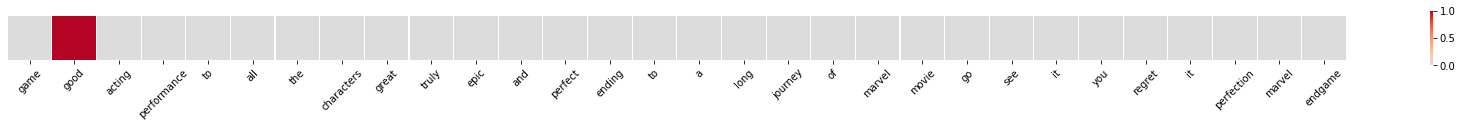

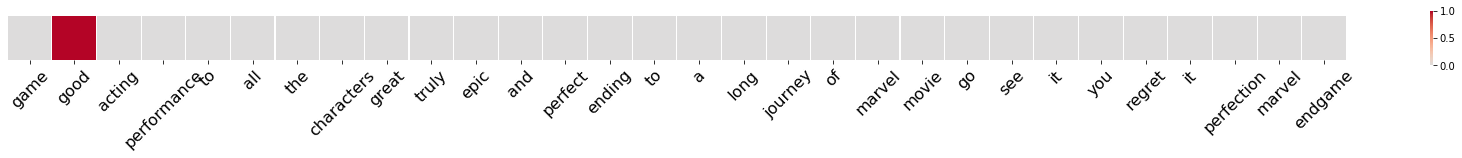

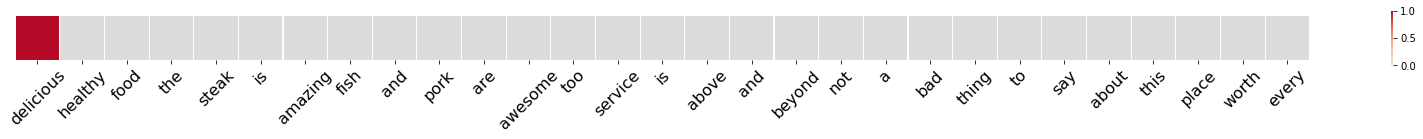

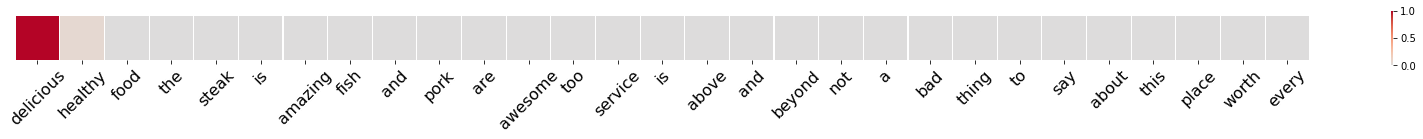

In [39]:
import matplotlib.pyplot as plt
import seaborn as sn

word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

def hierarchical_attention_analysis(review):        
    tokenized_sentences = doc2hierarchical(review)
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]
    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
            
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att = pred_attention[sent_idx][-len(words):]
                pred_att = np.expand_dims(pred_att, axis=0)
                break

        fig, ax = plt.subplots(figsize=(len(words), 1))
        plt.rc('xtick', labelsize=16)
        midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
        heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
        plt.xticks(rotation=45)
        plt.show()
        
def sequential_attention_analysis(review):        
    tokenized_sentence = doc2sequential(review)
    
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentence]))[0]
    
    for word_idx in range(MAX_SENTENCE_LENGTH):
        if tokenized_sentence[word_idx] != 0:
            words = [word_rev_index[word_id] for word_id in tokenized_sentence[word_idx:]]
            pred_att = pred_attention[-len(words):]
            pred_att = np.expand_dims(pred_att, axis=0)
            break

    fig, ax = plt.subplots(figsize=(len(words), 1))
    plt.rc('xtick', labelsize=16)
    midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
    heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
    plt.xticks(rotation=45)
    plt.show()
    
def sequential_normatt_analysis(review):        
    tokenized_sentence = doc2sequential(review)
    
    pred_representations = sequence_encoder.predict(np.asarray([tokenized_sentence]))[0]
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentence]))[0]
    weighted_representations = pred_representations * np.expand_dims(pred_attention, axis=-1)
    normatt = np.linalg.norm(weighted_representations, axis=-1)
    
    # print(pred_attention)
    
    for word_idx in range(MAX_SENTENCE_LENGTH):
        if tokenized_sentence[word_idx] != 0:
            words = [word_rev_index[word_id] for word_id in tokenized_sentence[word_idx:]]
            pred_att = normatt[-len(words):]
            pred_att = np.expand_dims(pred_att, axis=0)
            break

    fig, ax = plt.subplots(figsize=(len(words), 1))
    plt.rc('xtick', labelsize=16)
    midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
    heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmax=1.0)
    plt.xticks(rotation=45)
    plt.show()
        
# hierarchical_attention_analysis("Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!")
# sequential_attention_analysis("Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!")

target_review = "Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic and perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!"
sequential_attention_analysis(target_review)
sequential_normatt_analysis(target_review)

# target_review = "Marvel 's The Avengers is quite possibly the greatest superhero movie in history. The combination of heroes mixes itself together into a concoction of personalities and superpowers which guarantees to impress."
target_review = "Delicious healthy food. The steak is amazing. Fish and pork are awesome too. Service is above and beyond. Not a bad thing to say about this place. Worth every penny!"
sequential_attention_analysis(target_review)
sequential_normatt_analysis(target_review)